- Since 01/19/2019
    - Half of all large down spikes (2+ std moves) have occurred before 11 am
    - A quarter of all large up spikes (2+ std moves) have occurred after 3 pm
    - **Avoid trying to defend call spreads after 3 pm**
    - **Avoid trying to defend put spreads before 11 am**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import tws_data 
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from ib_insync import *
import numpy as np
import pandas as pd
import datetime as dt
import time
pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline
from scipy.stats import norm as norm
import matplotlib.pyplot as plt
import requests as req
from bs4 import BeautifulSoup as bs
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import math
def time_block_strtoactual(i):
    curr_time_block = dt.datetime.today().replace(hour = 9, minute = 30, second = 0, microsecond = 0) + dt.timedelta(minutes = 30*(i-1))
    return curr_time_block.strftime("%H:%M")

In [2]:
os.chdir('D:\Options Data\IB Intraday')

def create_dfrow(curr_option):
    df_row = pd.DataFrame({'Symbol': curr_option.contract.localSymbol, 
                           'Type':curr_option.contract.right, 
                           'Bid': curr_option.bid, 
                           'Ask': curr_option.ask, 
                           'Volume': curr_option.volume, 
                           'Strike': curr_option.contract.strike,
                           'Expiry': dt.datetime.strptime(curr_option.contract.lastTradeDateOrContractMonth, '%Y%m%d'),
                           'bidIV': curr_option.bidGreeks.impliedVol, 
                           'bidDelta': curr_option.bidGreeks.delta,
                           'bidGamma': curr_option.bidGreeks.gamma, 
                           'bidVega': curr_option.bidGreeks.vega,
                           'bidTheta': curr_option.bidGreeks.theta, 
                           'askIV': curr_option.askGreeks.impliedVol, 
                           'askDelta': curr_option.askGreeks.delta,
                           'askGamma': curr_option.askGreeks.gamma, 
                           'askVega': curr_option.askGreeks.vega,
                           'askTheta': curr_option.askGreeks.theta,
                           'modelIV': curr_option.modelGreeks.impliedVol, 
                           'modelDelta': curr_option.modelGreeks.delta,
                           'modelGamma': curr_option.modelGreeks.gamma, 
                           'modelVega': curr_option.modelGreeks.vega,
                           'modelTheta': curr_option.modelGreeks.theta}, index = [0])
    return df_row

def time_remaining(weekly_options, curr_spx):

    typ = weekly_options.reset_index().loc[0,'Type']

    try:
        interest_rate = bs(req.get('https://www.marketwatch.com/investing/bond/tmubmusd01m?countrycode=bx','lxml').text, 'lxml')
        interest_rate = float(interest_rate.select_one('h3[class*="intraday__price"]').select_one('bg-quote').text)/100
    except:
        interest_rate = 0.02422

    weekly_options['a'] = interest_rate - (weekly_options['modelIV']**2)/2

    if typ == 'P':
        weekly_options['b'] = weekly_options['modelIV']*norm.ppf(-weekly_options['modelDelta'])
    if typ == 'C':
        weekly_options['b'] = -weekly_options['modelIV']*norm.ppf(weekly_options['modelDelta'])
    weekly_options['c'] = np.log(curr_spx/weekly_options['Strike'])

    weekly_options_otm = weekly_options[abs(weekly_options.modelDelta) <= 0.5]
    weekly_options_itm = weekly_options[abs(weekly_options.modelDelta) > 0.5]

    if typ == 'P':
        weekly_options_otm['time_remaining'] = ((-weekly_options_otm.b - 
                                                 np.sqrt(weekly_options_otm.b**2 - 
                                                         4*weekly_options_otm.a*weekly_options_otm.c))/(2*weekly_options_otm.a))**2
        weekly_options_itm['time_remaining'] = ((-weekly_options_itm.b + 
                                                 np.sqrt(weekly_options_itm.b**2 - 
                                                         4*weekly_options_itm.a*weekly_options_itm.c))/(2*weekly_options_itm.a))**2
    if typ == 'C':
        weekly_options_otm['time_remaining'] = ((-weekly_options_otm.b + 
                                                 np.sqrt(weekly_options_otm.b**2 - 
                                                         4*weekly_options_otm.a*weekly_options_otm.c))/(2*weekly_options_otm.a))**2
        weekly_options_itm['time_remaining'] = ((-weekly_options_itm.b - 
                                                 np.sqrt(weekly_options_itm.b**2 - 
                                                         4*weekly_options_itm.a*weekly_options_itm.c))/(2*weekly_options_itm.a))**2
    weekly_times = pd.concat([weekly_options_otm, 
                              weekly_options_itm], axis = 0)[['Expiry','time_remaining']].dropna().groupby('Expiry').mean()

    del weekly_options['a'], weekly_options['b'], weekly_options['c'], weekly_options_itm, weekly_options_otm

    return weekly_options.merge(weekly_times.reset_index(), on = 'Expiry')

def get_spreads(weekly_options, curr_spx, curr_vix, curr_skew, expiry_index = 0, rowshift = 1, commissions = 0.0266):

    expirations_dates = weekly_options.Expiry.drop_duplicates().tolist()
    
    weekly_options = weekly_options[weekly_options.Expiry == expirations_dates[expiry_index]]

    typ = weekly_options.reset_index().loc[0,'Type']
    
    if typ == 'P':
        weekly_options = weekly_options.sort_values('Strike', ascending = False).reset_index(drop = True)
    if typ == 'C':
        weekly_options = weekly_options.sort_values('Strike', ascending = True).reset_index(drop = True)
        
    time_remaining = weekly_options.reset_index(drop = True).loc[0,'time_remaining']

    shorts = weekly_options[['Bid', 'Strike', 'bidDelta', 'bidGamma', 'bidTheta', 'bidVega']]
    shorts.columns = ['Price','Strike','Delta','Gamma','Theta','Vega']
    longs = weekly_options[['Ask','Strike', 'askDelta', 'askGamma','askTheta', 'askVega']]
    longs.columns = ['Price','Strike','Delta','Gamma','Theta','Vega']

    spreads = shorts - longs.shift(-rowshift)
    spreads['Short_Strike'] = shorts.Strike
    spreads['Short_Delta'] = shorts.Delta
    spreads['Long_Strike'] = longs.Strike.shift(-rowshift)
    spreads = spreads[['Short_Strike', 'Long_Strike', 'Short_Delta', 'Price',
                       'Strike', 'Delta', 'Gamma', 'Theta', 'Vega']]

    spreads['Credit'] = spreads.Price - commissions

    if typ == 'P':
        spreads['MaxLoss'] = (-spreads.Strike + spreads.Credit)*100
        spreads['BreakEven'] = spreads['Short_Strike'] - spreads.Credit
    if typ == 'C':
        spreads['MaxLoss'] = (spreads.Strike + spreads.Credit)*100
        spreads['BreakEven'] = spreads['Short_Strike'] + spreads.Credit

    del spreads['Price'], spreads['Strike']

    spreads = spreads[spreads.Credit > 0].dropna().reset_index(drop = True)

    stepsize = 0.01
    period_iv = np.sqrt(time_remaining)*curr_vix/100
    
    skew_implied_2std = 0.027*(curr_skew - 100)/10
    skew_implied_3std = 0.006*(curr_skew - 100)/10

    period_iv_2std = (-2*period_iv)/norm.ppf(skew_implied_2std,0,1)
    period_iv_3std = (-3*period_iv)/norm.ppf(skew_implied_3std,0,1)

    spreads['EV'] = np.nan
    spreads['Win Prob'] = np.nan

    ev_lsts = []

    for idx, row in spreads.iterrows():

        if typ == 'P':
            ev_df = pd.DataFrame({'SPX': np.arange(row.Long_Strike, row.Short_Strike + stepsize, stepsize)})
            ev_df = ev_df[(ev_df['SPX'] < row.Short_Strike + stepsize)]
            ev_df['PnL'] = ev_df['SPX'] - row.Short_Strike + row.Credit
        if typ == 'C':
            ev_df = pd.DataFrame({'SPX': np.arange(row.Short_Strike, row.Long_Strike + stepsize, stepsize)})
            ev_df = ev_df[(ev_df['SPX'] < row.Long_Strike + stepsize)]
            ev_df['PnL'] = row.Short_Strike - ev_df['SPX'] + row.Credit

        ev_df['Prob'] = norm.cdf(ev_df['SPX']/curr_spx - 1,0, period_iv)
        ev_df[ev_df.SPX < curr_spx*(1 - period_iv)]['Prob'] = norm.cdf(ev_df[ev_df.SPX < curr_spx*(1 - period_iv)]['SPX']/curr_spx - 1,
                                                                       0, period_iv_2std)
        ev_df[ev_df.SPX < curr_spx*(1 - 2*period_iv)]['Prob'] = norm.cdf(ev_df[ev_df.SPX < curr_spx*(1 - 2*period_iv)]['SPX']/curr_spx - 1,
                                                                         0, period_iv_3std)
        
        ev_df[ev_df.SPX > curr_spx*(1 - period_iv)]['Prob'] = 1 - norm.cdf(ev_df[ev_df.SPX > curr_spx*(1 - period_iv)]['SPX']/curr_spx - 1,
                                                                       0, period_iv_2std)
        ev_df[ev_df.SPX > curr_spx*(1 - 2*period_iv)]['Prob'] = 1 - norm.cdf(ev_df[ev_df.SPX > curr_spx*(1 - 2*period_iv)]['SPX']/curr_spx - 1,
                                                                         0, period_iv_3std)
        
        lb = ev_df.loc[0,'Prob']
        ub = ev_df.loc[len(ev_df) - 1,'Prob']
        ev_df['Prob'] = ev_df['Prob'].diff()
        ev_df.loc[0,'Prob'] = lb
        ev_df.loc[len(ev_df) - 1, 'Prob'] = 1 - ub
        ev_df['EV'] = ev_df.Prob*ev_df.PnL

        ev_lsts.append(ev_df)
        total_ev = sum(ev_df['EV'])
        win_prob = sum(ev_df[ev_df['PnL'] >= 0]['Prob'])

        spreads.loc[idx, 'EV'] = total_ev
        spreads.loc[idx, 'Win Prob'] = win_prob
    
    spreads['Expiry'] = expirations_dates[expiry_index]
    spreads.Expiry = pd.to_datetime(spreads['Expiry'])
    return spreads, ev_lsts


#%% Stats
def get_block_stats(curr_block, block_label):

    curr_spx_trend = curr_block.close_spx - curr_block.reset_index(drop = True).loc[0,'close_spx']
    curr_vix_trend = curr_block.close_vix - curr_block.reset_index(drop = True).loc[0,'close_vix']
    spx_X = curr_spx_trend.index ## X usually means our input variables (or independent variables)
    spx_Y = curr_spx_trend ## Y usually means our output/dependent variable

    vix_X = curr_vix_trend.index ## X usually means our input variables (or independent variables)
    vix_Y = curr_vix_trend ## Y usually means our output/dependent variable

    # # Note the difference in argument order
    spx_ols = sm.OLS(spx_Y, spx_X).fit().summary()
    spx_ols_r2 = float(pd.read_html(spx_ols.tables[0].as_html())[0].loc[1,3])
    spx_ols_coeff = float(pd.read_html(spx_ols.tables[1].as_html())[0].loc[1,1])

    vix_ols = sm.OLS(vix_Y, vix_X).fit().summary()
    vix_ols_r2 = float(pd.read_html(vix_ols.tables[0].as_html())[0].loc[1,3])
    vix_ols_coeff = float(pd.read_html(vix_ols.tables[1].as_html())[0].loc[1,1])

    spx_bar_std = np.std(curr_block.close_spx/curr_block.open_spx)
    vix_bar_std = np.std(curr_block.close_vix/curr_block.open_vix)

    spx_block_std = np.std((curr_block.close_spx.shift(1)/curr_block.close_spx).dropna())
    vix_block_std = np.std((curr_block.close_vix.shift(1)/curr_block.close_vix).dropna())

    spx_adf_sig = ts.adfuller(np.log(curr_block.close_spx))[1]
    vix_adf_sig = ts.adfuller(np.log(curr_block.close_vix))[1]

    spx_block_return = curr_block.loc[len(curr_block) - 1, 'close_spx']/curr_block.loc[0, 'close_spx'] - 1
    vix_block_return = curr_block.loc[len(curr_block) - 1, 'close_vix']/curr_block.loc[0, 'close_vix'] - 1
    
    spx_vix_corr = np.corrcoef(curr_block.close_spx,curr_block.close_vix)[0,1]
    
    block_stats = pd.DataFrame({'Block_Label': block_label,
                                'SPX_OLS_Coeff': spx_ols_coeff, 
                                'SPX_OLS_R2': spx_ols_r2,
                                'SPX_bar_std': spx_bar_std,
                                'SPX_block_std': spx_block_std,
                                'SPX_adf_sig': spx_adf_sig,
                                'SPX_block_return': spx_block_return,
                                'VIX_OLS_Coeff': vix_ols_coeff, 
                                'VIX_OLS_R2': vix_ols_r2,
                                'VIX_bar_std': vix_bar_std,
                                'VIX_block_std': vix_block_std,
                                'VIX_adf_sig': vix_adf_sig,
                                'VIX_block_return': vix_block_return,
                                'SPX_VIX_corr': spx_vix_corr,
                                'VIX_open': curr_block.loc[0,'close_vix']}, index = [0])
    return block_stats

def day_block_stats(curr_data):
    block_label = 1
    day_timeblock_stats = []
    for time_block in range(0,len(curr_data),30):
        if time_block < len(curr_data):
            curr_block = curr_data.loc[time_block:time_block + 30, :].reset_index(drop = True)
            day_timeblock_stats.append(get_block_stats(curr_block, "Time{}".format(block_label)))
        block_label += 1

    day_timeblock_stats = pd.concat(day_timeblock_stats, axis = 0).reset_index(drop = True)

    return day_timeblock_stats
#%%


In [3]:
client_id = 12

ib = IB()
ib.connect('127.0.0.1', 7496, clientId=client_id)



<IB connected to 127.0.0.1:7496 clientId=12>

In [4]:
spx = Index('SPX', 'CBOE')
vix = Index('VIX', 'CBOE')

skew = Index('SKEW', 'CBOE')
ib.qualifyContracts(skew)
ib.qualifyContracts(spx)

ib.reqHeadTimeStamp(spx, whatToShow='TRADES', useRTH=True)
ib.reqHeadTimeStamp(vix, whatToShow='TRADES', useRTH=True)

end_date = '' #'20100506 13:00:00 PST'
duration = '1 D'

spx_bars = ib.reqHistoricalData(
        spx,
        endDateTime=end_date,
        durationStr=duration,
        barSizeSetting='1 min',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)

vix_bars = ib.reqHistoricalData(
        vix,
        endDateTime=end_date,
        durationStr=duration,
        barSizeSetting='1 min',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)

spx_df = util.df(spx_bars).set_index('date')
spx_df.index = pd.to_datetime(spx_df.index)

vix_df = util.df(vix_bars).set_index('date')
vix_df.index = pd.to_datetime(vix_df.index)

curr_spx = spx_df.reset_index().loc[len(spx_df) - 1, 'close']

curr_vix = vix_df.reset_index().loc[len(vix_df) - 1, 'close']

curr_skew = ib.reqMktData(skew, '', False, False).marketPrice()

if math.isnan(curr_skew):
    skew = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/skewdailyprices.csv', 
                       skiprows = 1)[['Date','SKEW']].set_index('Date')
    curr_skew = skew.reset_index().loc[len(skew) - 1, 'SKEW']

chains = ib.reqSecDefOptParams(spx.symbol, '', spx.secType, spx.conId)

chains_df = util.df(chains)
chain = next(c for c in chains if c.tradingClass == 'SPXW' and c.exchange == 'SMART')

all_expirations = sorted(exp for exp in chain.expirations)

In [5]:
expirations = all_expirations[-2:]
expirations_dates = [dt.datetime.strptime(x, '%Y%m%d') for x in expirations]
#dte_expirations = list(filter(lambda x: x <= 10 and x > 0, [(expir - dt.datetime.today()).days for expir in expirations_dates]))
dte_expirations = [(expir - dt.datetime.today()).days for expir in expirations_dates]
#expirations = expirations[:len(dte_expirations)]

bounds_lst = [curr_spx*(5*curr_vix/(100*np.sqrt(365.25/dte))) for dte in dte_expirations]

In [230]:
contracts_list = []

for bounds, expiration in zip(bounds_lst, expirations):
    strikes = [strike for strike in chain.strikes
               if strike % 5 == 0
               and curr_spx - bounds < strike < curr_spx + bounds]
    
    rights = ['P', 'C']
    
    curr_contracts = [Option('SPX', expiration, strike, right, 'SMART')
                      for right in rights
                      for strike in strikes]
    contracts_list += [curr_contracts]
    
puts_list = []
calls_list = []

for contracts in contracts_list:
    ib.qualifyContracts(*contracts)
    spx_options = ib.reqTickers(*contracts)
    
    puts_rows = []
    calls_rows = []

    for curr_option in spx_options:
        try:
            curr_row = create_dfrow(curr_option)
            if curr_option.contract.right == 'P':
                puts_rows.append(curr_row)
            elif curr_option.contract.right == 'C':
                calls_rows.append(curr_row)
        except:
            continue

    puts = pd.concat(puts_rows).reset_index(drop = True).sort_values(['Expiry','Strike'])
    calls = pd.concat(calls_rows).reset_index(drop = True).sort_values(['Expiry','Strike'])
    puts = time_remaining(puts, curr_spx)
    calls = time_remaining(calls, curr_spx)
    puts_list.append(puts)
    calls_list.append(calls)
    time.sleep(5)
    
ib.disconnect()

puts_df = pd.concat(puts_list,axis = 0).reset_index(drop = True)
calls_df = pd.concat(calls_list,axis = 0).reset_index(drop = True)

curr_time = dt.datetime.now().strftime('%Y%m%d-%H-%M')
puts_df.to_csv('ib_puts' + curr_time + '.csv')
calls_df.to_csv('ib_calls' + curr_time + '.csv')

Started to throttle requests
Error 200, reqId 13: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2560.0, right='P', exchange='SMART')
Error 200, reqId 17: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2565.0, right='P', exchange='SMART')
Error 200, reqId 18: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2055.0, right='P', exchange='SMART')
Error 200, reqId 19: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3080.0, right='P', exchange='SMART')
Error 200, reqId 20: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2570.0, right='P', exchange='SMART')
Error 200, 

Error 200, reqId 77: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2155.0, right='P', exchange='SMART')
Error 200, reqId 79: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2160.0, right='P', exchange='SMART')
Error 200, reqId 83: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2165.0, right='P', exchange='SMART')
Error 200, reqId 85: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2170.0, right='P', exchange='SMART')
Error 200, reqId 86: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1660.0, right='P', exchange='SMART')
Error 200, reqId 87: No security definit

Error 200, reqId 155: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1780.0, right='P', exchange='SMART')
Error 200, reqId 156: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2805.0, right='P', exchange='SMART')
Error 200, reqId 157: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2295.0, right='P', exchange='SMART')
Error 200, reqId 160: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1790.0, right='P', exchange='SMART')
Error 200, reqId 161: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2815.0, right='P', exchange='SMART')
Error 200, reqId 162: No security d

Error 200, reqId 225: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1905.0, right='P', exchange='SMART')
Error 200, reqId 227: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2420.0, right='P', exchange='SMART')
Error 200, reqId 228: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1910.0, right='P', exchange='SMART')
Error 200, reqId 229: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2935.0, right='P', exchange='SMART')
Error 200, reqId 231: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3450.0, right='P', exchange='SMART')
Error 200, reqId 234: No security d

Error 200, reqId 293: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2520.0, right='P', exchange='SMART')
Error 200, reqId 294: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2010.0, right='P', exchange='SMART')
Error 200, reqId 295: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3035.0, right='P', exchange='SMART')
Error 200, reqId 300: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2530.0, right='P', exchange='SMART')
Error 200, reqId 301: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2020.0, right='P', exchange='SMART')
Error 200, reqId 302: No security d

Error 200, reqId 357: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2620.0, right='C', exchange='SMART')
Error 200, reqId 355: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2105.0, right='C', exchange='SMART')
Error 200, reqId 356: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3130.0, right='C', exchange='SMART')
Error 200, reqId 358: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2110.0, right='C', exchange='SMART')
Error 200, reqId 361: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2115.0, right='C', exchange='SMART')
Error 200, reqId 362: No security d

Error 200, reqId 427: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2745.0, right='C', exchange='SMART')
Error 200, reqId 428: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2235.0, right='C', exchange='SMART')
Error 200, reqId 432: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1730.0, right='C', exchange='SMART')
Error 200, reqId 431: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2240.0, right='C', exchange='SMART')
Error 200, reqId 434: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2245.0, right='C', exchange='SMART')
Error 200, reqId 433: No security d

Error 200, reqId 503: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2370.0, right='C', exchange='SMART')
Error 200, reqId 504: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1860.0, right='C', exchange='SMART')
Error 200, reqId 509: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2380.0, right='C', exchange='SMART')
Error 200, reqId 505: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2885.0, right='C', exchange='SMART')
Error 200, reqId 510: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1870.0, right='C', exchange='SMART')
Error 200, reqId 511: No security d

Error 200, reqId 568: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2985.0, right='C', exchange='SMART')
Error 200, reqId 572: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1965.0, right='C', exchange='SMART')
Error 200, reqId 574: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2480.0, right='C', exchange='SMART')
Error 200, reqId 576: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2995.0, right='C', exchange='SMART')
Error 200, reqId 575: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1970.0, right='C', exchange='SMART')
Error 200, reqId 577: No security d

Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2580.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2070.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3095.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2585.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2590.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2080.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2595.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2085.0, right='P', exchange='SMART')
Unknown 

Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2260.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2265.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2270.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1760.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2785.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2280.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1770.0, right='P', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2795.0, right='P', exchange='SMART')
Unknown 

Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2605.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2095.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3120.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2610.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2615.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2105.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3130.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2620.0, right='C', exchange='SMART')
Unknown 

Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1780.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2805.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2295.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1790.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2815.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2305.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2310.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2315.0, right='C', exchange='SMART')
Unknown 

Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2985.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1965.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2480.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1970.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2995.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2485.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2490.0, right='C', exchange='SMART')
Unknown contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1980.0, right='C', exchange='SMART')
Unknown 

Error 200, reqId 654: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2605.0, right='P', exchange='SMART')
Error 200, reqId 655: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2095.0, right='P', exchange='SMART')
Error 200, reqId 656: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3120.0, right='P', exchange='SMART')
Error 200, reqId 657: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2610.0, right='P', exchange='SMART')
Error 200, reqId 660: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2615.0, right='P', exchange='SMART')
Error 200, reqId 661: No security d

Error 200, reqId 725: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2220.0, right='P', exchange='SMART')
Error 200, reqId 726: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1710.0, right='P', exchange='SMART')
Error 200, reqId 727: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2735.0, right='P', exchange='SMART')
Error 200, reqId 731: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2230.0, right='P', exchange='SMART')
Error 200, reqId 732: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1720.0, right='P', exchange='SMART')
Error 200, reqId 733: No security d

Error 200, reqId 799: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1840.0, right='P', exchange='SMART')
Error 200, reqId 800: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2865.0, right='P', exchange='SMART')
Error 200, reqId 801: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2355.0, right='P', exchange='SMART')
Error 200, reqId 803: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2360.0, right='P', exchange='SMART')
Error 200, reqId 807: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2365.0, right='P', exchange='SMART')
Error 200, reqId 809: No security d

Error 200, reqId 865: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2460.0, right='P', exchange='SMART')
Error 200, reqId 869: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2465.0, right='P', exchange='SMART')
Error 200, reqId 870: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1955.0, right='P', exchange='SMART')
Error 200, reqId 872: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2470.0, right='P', exchange='SMART')
Error 200, reqId 873: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1960.0, right='P', exchange='SMART')
Error 200, reqId 874: No security d

Error 200, reqId 935: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2565.0, right='C', exchange='SMART')
Error 200, reqId 936: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2055.0, right='C', exchange='SMART')
Error 200, reqId 937: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3080.0, right='C', exchange='SMART')
Error 200, reqId 938: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2570.0, right='C', exchange='SMART')
Error 200, reqId 939: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2060.0, right='C', exchange='SMART')
Error 200, reqId 940: No security d

Error 200, reqId 997: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2160.0, right='C', exchange='SMART')
Error 200, reqId 1001: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2165.0, right='C', exchange='SMART')
Error 200, reqId 1003: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2170.0, right='C', exchange='SMART')
Error 200, reqId 1004: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1660.0, right='C', exchange='SMART')
Error 200, reqId 1005: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2685.0, right='C', exchange='SMART')
Error 200, reqId 1009: No secur

Error 200, reqId 1074: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2805.0, right='C', exchange='SMART')
Error 200, reqId 1075: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2295.0, right='C', exchange='SMART')
Error 200, reqId 1078: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1790.0, right='C', exchange='SMART')
Error 200, reqId 1079: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2815.0, right='C', exchange='SMART')
Error 200, reqId 1080: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2305.0, right='C', exchange='SMART')
Error 200, reqId 1082: No secu

Error 200, reqId 1146: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1910.0, right='C', exchange='SMART')
Error 200, reqId 1147: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2935.0, right='C', exchange='SMART')
Error 200, reqId 1149: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3450.0, right='C', exchange='SMART')
Error 200, reqId 1150: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=1915.0, right='C', exchange='SMART')
Error 200, reqId 1152: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2430.0, right='C', exchange='SMART')
Error 200, reqId 1153: No secu

Error 200, reqId 1213: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3035.0, right='C', exchange='SMART')
Error 200, reqId 1216: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2015.0, right='C', exchange='SMART')
Error 200, reqId 1218: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2530.0, right='C', exchange='SMART')
Error 200, reqId 1219: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=2020.0, right='C', exchange='SMART')
Error 200, reqId 1220: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20190930', strike=3045.0, right='C', exchange='SMART')
Error 200, reqId 1221: No secu

TypeError: 'numpy.float64' object is not callable

In [41]:
# positions = list(filter(lambda x: x.account == 'U1625568', ib.positions()))

# today_string = dt.datetime.today().strftime('%Y%m%d')

# curr_positions = list(filter(lambda x: x.contract.lastTradeDateOrContractMonth == today_string, positions))

# curr_positions = pd.DataFrame({'Contract':[pos.contract for pos in curr_positions],
#                                'Holding':[pos.position for pos in curr_positions],
#                                'Underlying':[pos.contract.symbol for pos in curr_positions]})
ib.disconnect()

In [235]:
calls_df[(calls_df.Expiry > dt.datetime(2019,9,30)) &
         (calls_df.Strike > curr_spx)]

,Ask,Bid,Expiry,Strike,Symbol,Type,Volume,askDelta,askGamma,askIV,...,bidGamma,bidIV,bidTheta,bidVega,modelDelta,modelGamma,modelIV,modelTheta,modelVega,time_remaining
176,143.4000,142.2000,2019-12-31,"2,825.0000",SPXW 191231C02825000,C,nan,0.5280,0.0011,0.1429,...,0.0011,0.1417,-0.3333,9.8600,0.5279,0.0011,0.1419,-0.3337,9.8599,0.6594
177,128.4000,127.2000,2019-12-31,"2,850.0000",SPXW 191231C02850000,C,nan,0.4993,0.0012,0.1395,...,0.0012,0.1383,-0.3234,9.8840,0.4969,0.0012,0.1330,-0.3144,9.8837,0.6594
178,114.1000,112.9000,2019-12-31,"2,875.0000",SPXW 191231C02875000,C,nan,0.4694,0.0012,0.1359,...,0.0012,0.1346,-0.3116,9.8536,0.4689,0.0012,0.1350,-0.3122,9.8539,0.6594
179,100.5000,99.5000,2019-12-31,"2,900.0000",SPXW 191231C02900000,C,nan,0.4382,0.0012,0.1322,...,0.0012,0.1310,-0.2981,9.7615,0.4326,0.0013,0.1255,-0.2881,9.7425,0.6594
180,88.0000,86.9000,2019-12-31,"2,925.0000",SPXW 191231C02925000,C,nan,0.4062,0.0012,0.1287,...,0.0012,0.1276,-0.2836,9.6028,0.4057,0.0012,0.1283,-0.2848,9.6068,0.6594
181,76.2000,75.2000,2019-12-31,"2,950.0000",SPXW 191231C02950000,C,nan,0.3735,0.0012,0.1254,...,0.0012,0.1243,-0.2676,9.3717,0.3732,0.0012,0.1251,-0.2692,9.3802,0.6594
182,65.4000,64.5000,2019-12-31,"2,975.0000",SPXW 191231C02975000,C,nan,0.3406,0.0012,0.1223,...,0.0012,0.1212,-0.2504,9.0667,0.3403,0.0012,0.1221,-0.2523,9.0815,0.6594
183,55.8000,54.8000,2019-12-31,"3,000.0000",SPXW 191231C03000000,C,1.0000,0.3080,0.0012,0.1194,...,0.0012,0.1183,-0.2324,8.6906,0.3077,0.0012,0.1192,-0.2345,8.7118,0.6594
184,47.1000,46.2000,2019-12-31,"3,025.0000",SPXW 191231C03025000,C,nan,0.2756,0.0012,0.1165,...,0.0012,0.1154,-0.2136,8.2426,0.2756,0.0012,0.1165,-0.2162,8.2758,0.6594
185,39.5000,38.6000,2019-12-31,"3,050.0000",SPXW 191231C03050000,C,nan,0.2448,0.0011,0.1142,...,0.0011,0.1130,-0.1949,7.7423,0.2293,0.0011,0.1074,-0.1809,7.5108,0.6594


In [5]:
curr_time = '20190307-12-37'

puts_df = pd.read_csv('ib_puts' + curr_time + '.csv', index_col = 0)
calls_df = pd.read_csv('ib_calls' + curr_time + '.csv', index_col = 0)

puts_df.Expiry = pd.to_datetime(puts_df.Expiry)
calls_df.Expiry = pd.to_datetime(calls_df.Expiry)

In [12]:
unique_expiries_idx = 1
z_val = 'modelDelta'


puts_surface = puts_df[['Expiry','Strike','modelDelta','modelGamma','modelIV','modelTheta','modelVega','time_remaining']]
calls_surface = calls_df[['Expiry','Strike','modelDelta','modelGamma','modelIV','modelTheta','modelVega','time_remaining']]

unique_expiries = puts_surface.Expiry.drop_duplicates().tolist()

surface_data = calls_surface.copy()

surface_data = surface_data[surface_data.Expiry >= unique_expiries[unique_expiries_idx]].reset_index(drop = True)

surface_data = surface_data[surface_data.Strike.isin(surface_data[surface_data.Expiry == unique_expiries[unique_expiries_idx]].Strike.tolist())]

number_of_curr_strikes = len(surface_data[surface_data.Expiry == unique_expiries[unique_expiries_idx]])
number_of_curr_expiries = len(surface_data.Expiry.drop_duplicates())

z = surface_data[z_val].reshape(number_of_curr_expiries, number_of_curr_strikes)
x = surface_data.Strike.reshape(number_of_curr_expiries, number_of_curr_strikes)
y = surface_data.time_remaining.reshape(number_of_curr_expiries, number_of_curr_strikes)

surface1 = go.Surface(x = x, 
                      y = y, 
                      z = z,
                      name = z_val)

layout = go.Layout(
                title='{} Plot'.format(z_val),
                autosize=True,
                showlegend = False,
                scene=dict(
                    aspectmode = 'manual',
                    aspectratio = dict(x = 2,
                                       y = 2,
                                       z = 1),
                    camera = dict(up = dict(x = 0,
                                            y = 0,
                                            z = 1),
                                  center = dict(x = 0,
                                                y = 0,
                                                z = 0),
                                  eye = dict(x = 1,
                                             y = 1,
                                             z = 0.5)),
                    xaxis=dict(
                        title='Underlying Price',
                        gridcolor='rgb(255, 255, 255)',
                        zerolinecolor='rgb(255, 255, 255)',
                        showbackground=True,
                        backgroundcolor='rgb(230, 230,230)'
                    ),
                    yaxis=dict(
                        title='DTE Change',
                        gridcolor='rgb(255, 255, 255)',
                        zerolinecolor='rgb(255, 255, 255)',
                        showbackground=True,
                        backgroundcolor='rgb(230, 230,230)'
                    ),
                    zaxis=dict(
                        title = z_val,
                        gridcolor='rgb(255, 255, 255)',
                        zerolinecolor='rgb(255, 255, 255)',
                        showbackground=True,
                        backgroundcolor='rgb(230, 230,230)'
                    )
                )
            )

data = [surface1]
figure = dict(data=data, layout=layout)
iplot(figure)

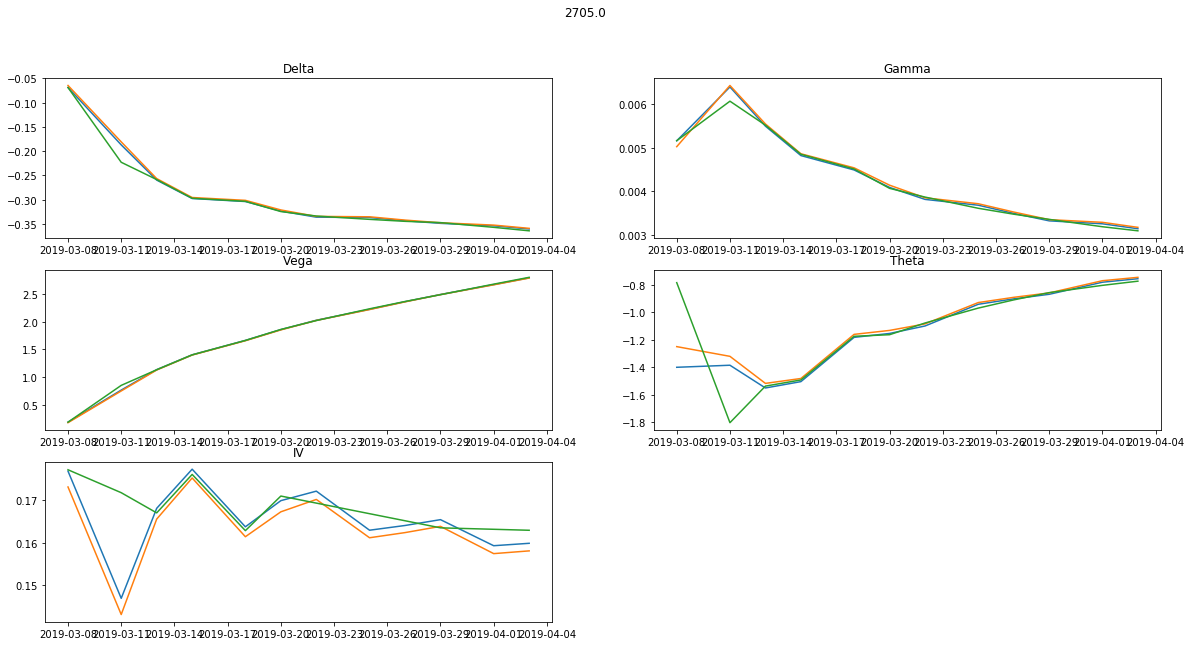

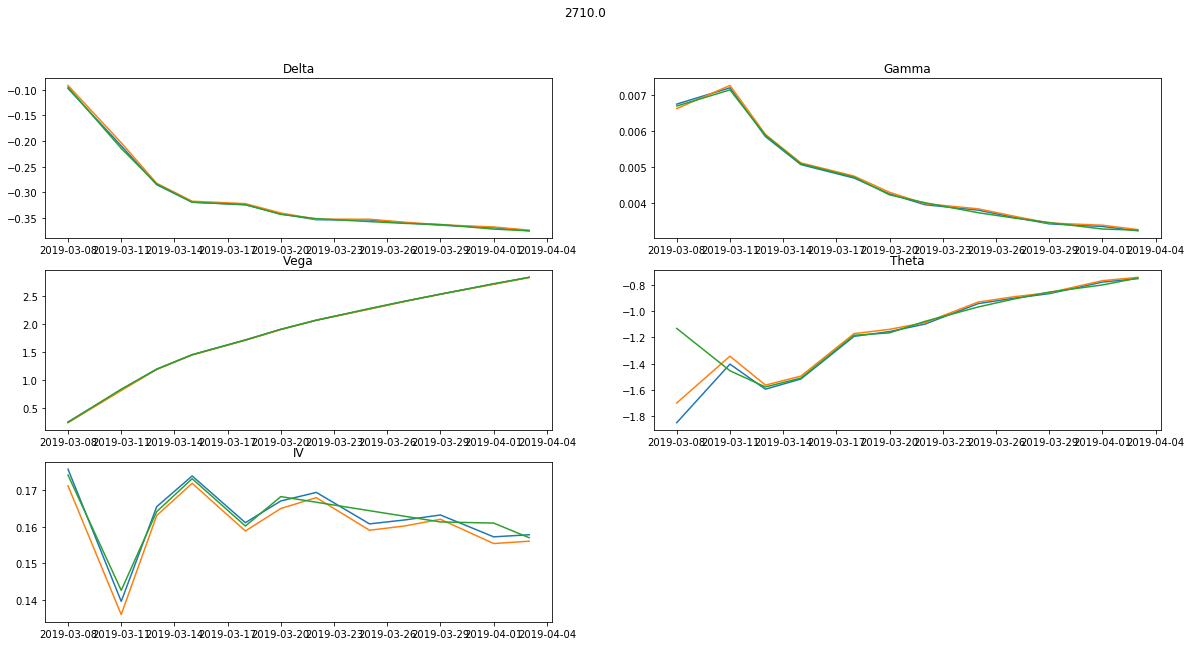

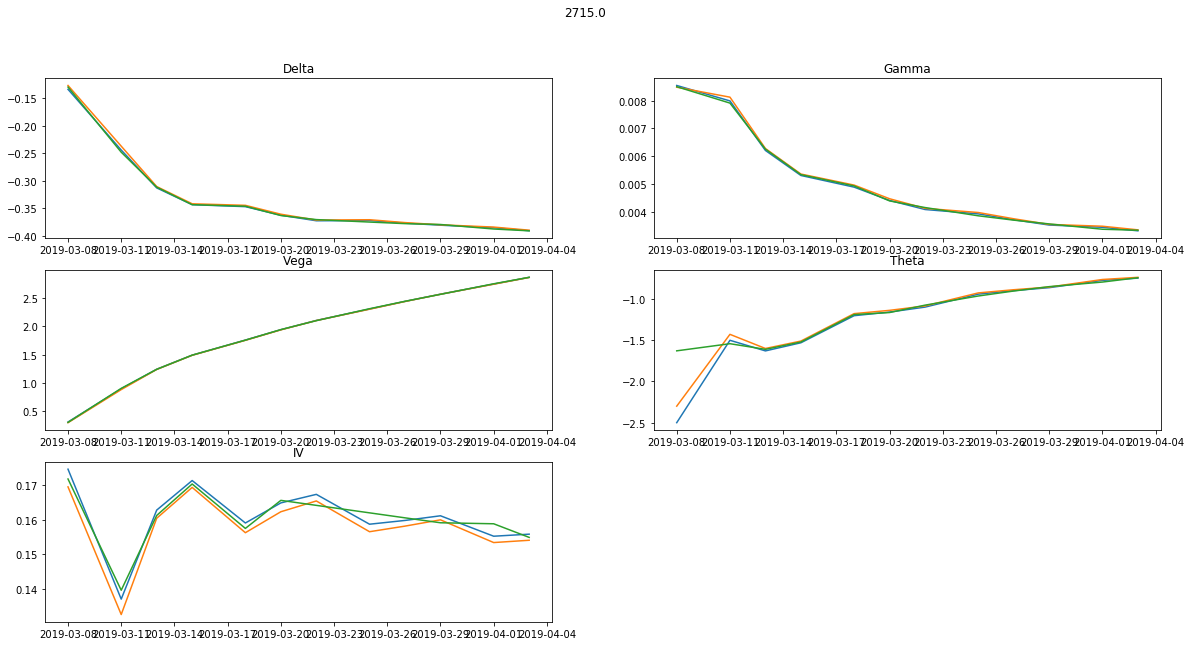

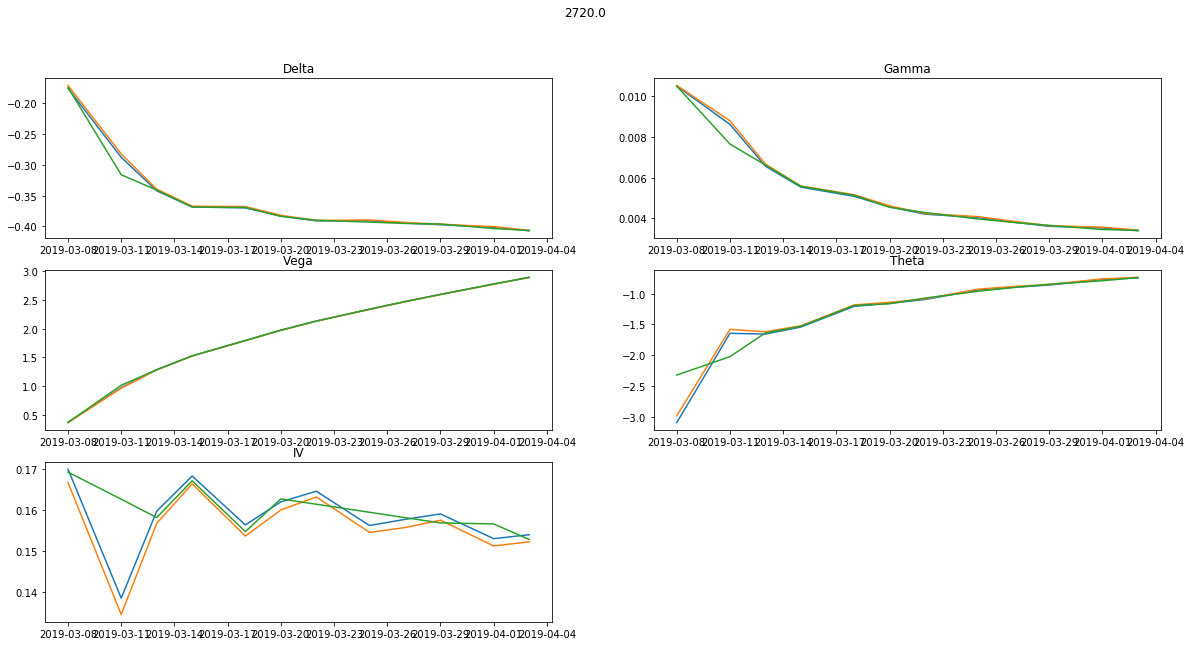

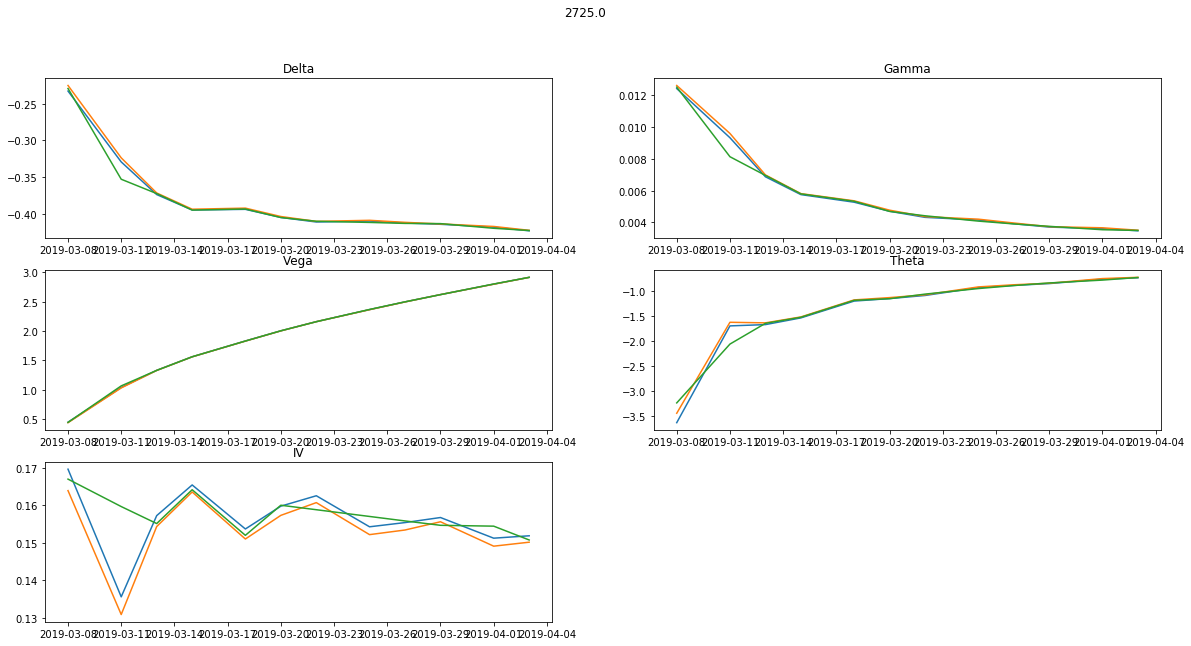

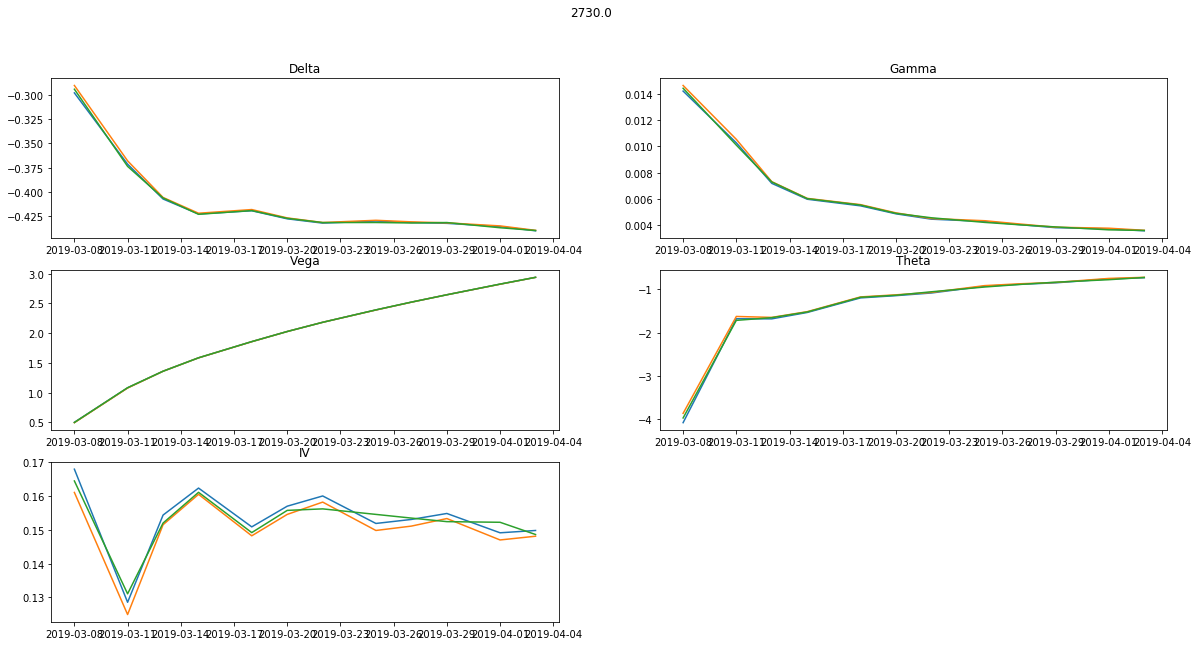

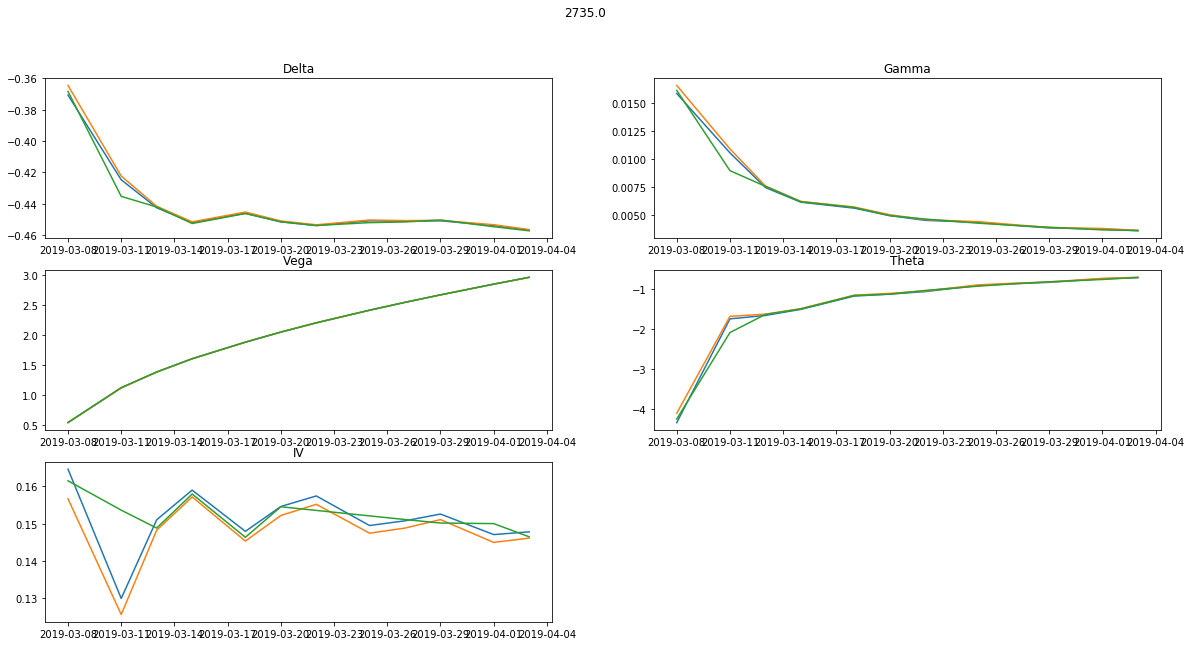

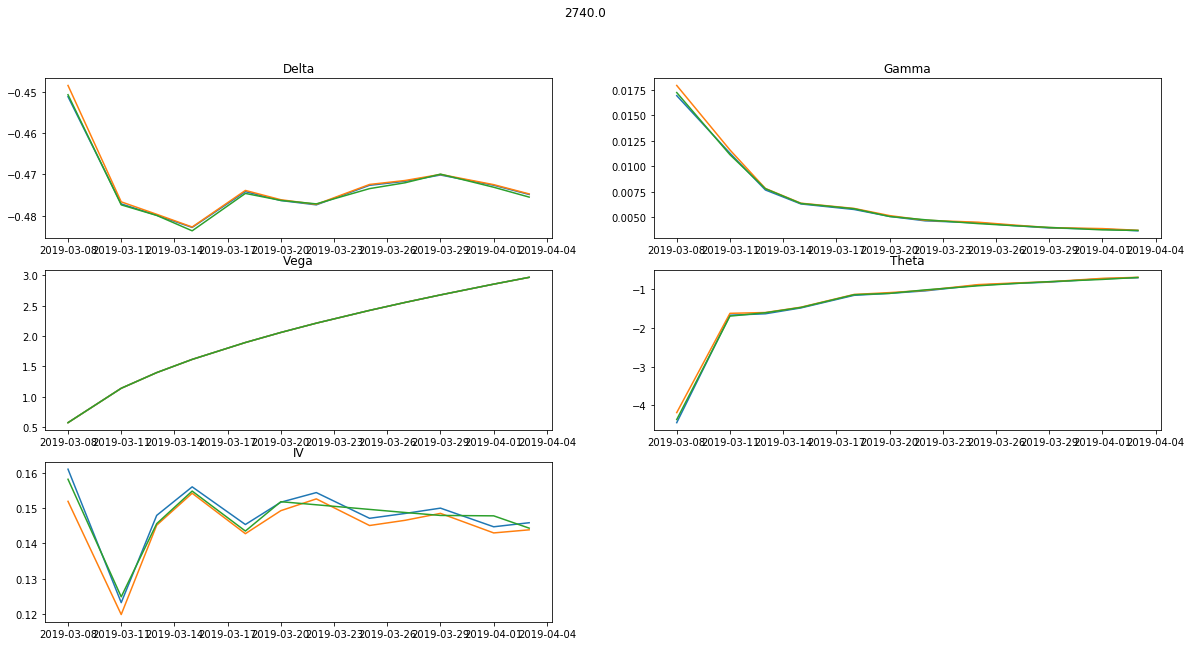

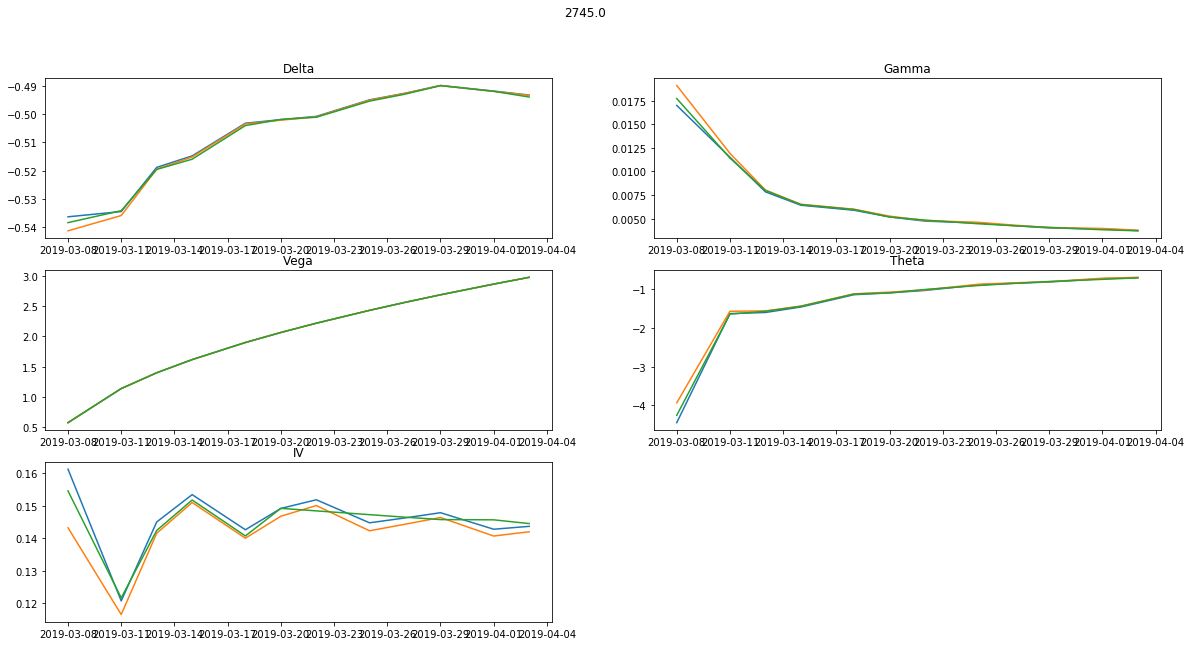

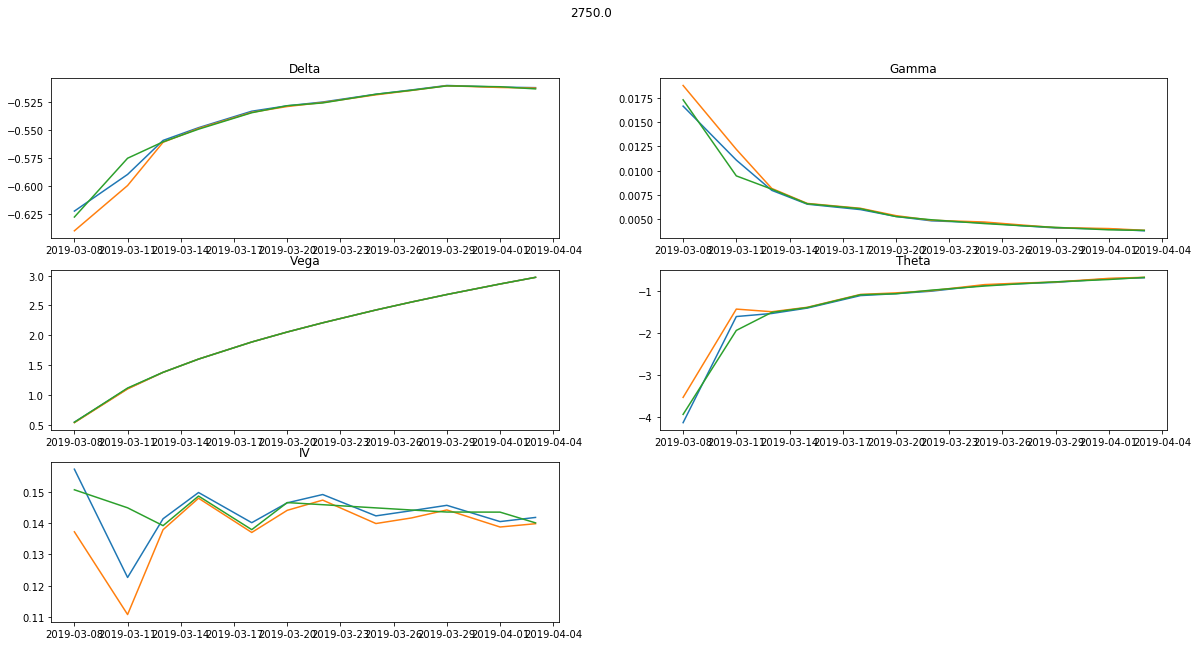

In [75]:
options_df = puts_df.copy()

for strike in options_df.Strike.drop_duplicates():
    curr_strike_df = options_df[options_df.Strike == strike]
    
    curr_deltas = curr_strike_df[['Expiry'] + list(filter(lambda x: 'Delta' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')
    curr_gammas = curr_strike_df[['Expiry'] + list(filter(lambda x: 'Gamma' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')
    curr_vegas = curr_strike_df[['Expiry'] + list(filter(lambda x: 'Vega' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')
    curr_thetas = curr_strike_df[['Expiry'] + list(filter(lambda x: 'Theta' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')
    curr_ivs = curr_strike_df[['Expiry'] + list(filter(lambda x: 'IV' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')

    fig = plt.figure(figsize = (20,10))
    fig.suptitle(strike)
    plt.subplot(3, 2, 1)
    plt.plot(curr_deltas)

    plt.subplot(3, 2, 2)
    plt.plot(curr_gammas)

    plt.subplot(3, 2, 3)
    plt.plot(curr_vegas)

    plt.subplot(3, 2, 4)
    plt.plot(curr_thetas)
    
    plt.subplot(3, 2, 5)
    plt.plot(curr_ivs)
    
    ax1 = fig.add_subplot(321)
    ax2 = fig.add_subplot(322)
    ax3 = fig.add_subplot(323)
    ax4 = fig.add_subplot(324)
    ax5 = fig.add_subplot(325)
    ax1.title.set_text('Delta')
    ax2.title.set_text('Gamma')
    ax3.title.set_text('Vega')
    ax4.title.set_text('Theta')
    ax5.title.set_text('IV')
    
    plt.show()
    if strike > 2745:
        break

In [ ]:
options_df = puts_df.copy()

for strike in options_df.Strike.drop_duplicates():
    curr_strike_df = options_df[options_df.Strike == strike]
    
    curr_deltas = curr_strike_df[['Expiry'] + list(filter(lambda x: 'Delta' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')
    curr_gammas = curr_strike_df[['Expiry'] + list(filter(lambda x: 'Gamma' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')
    curr_vegas = curr_strike_df[['Expiry'] + list(filter(lambda x: 'Vega' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')
    curr_thetas = curr_strike_df[['Expiry'] + list(filter(lambda x: 'Theta' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')
    curr_ivs = curr_strike_df[['Expiry'] + list(filter(lambda x: 'IV' in x, curr_strike_df.columns.tolist()))].set_index('Expiry')

    fig = plt.figure(figsize = (20,10))
    fig.suptitle(strike)
    plt.subplot(2, 3, 1)
    plt.plot(curr_deltas)

    plt.subplot(2, 3, 2)
    plt.plot(curr_gammas)

    plt.subplot(2, 3, 3)
    plt.plot(curr_vegas)

    plt.subplot(2, 3, 4)
    plt.plot(curr_thetas)
    
    plt.subplot(2, 3, 5)
    plt.plot(curr_ivs)
    
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)
    ax1.title.set_text('Delta')
    ax2.title.set_text('Gamma')
    ax3.title.set_text('Vega')
    ax4.title.set_text('Theta')
    ax5.title.set_text('IV')
    
    plt.show()
    if strike > 2745:
        break

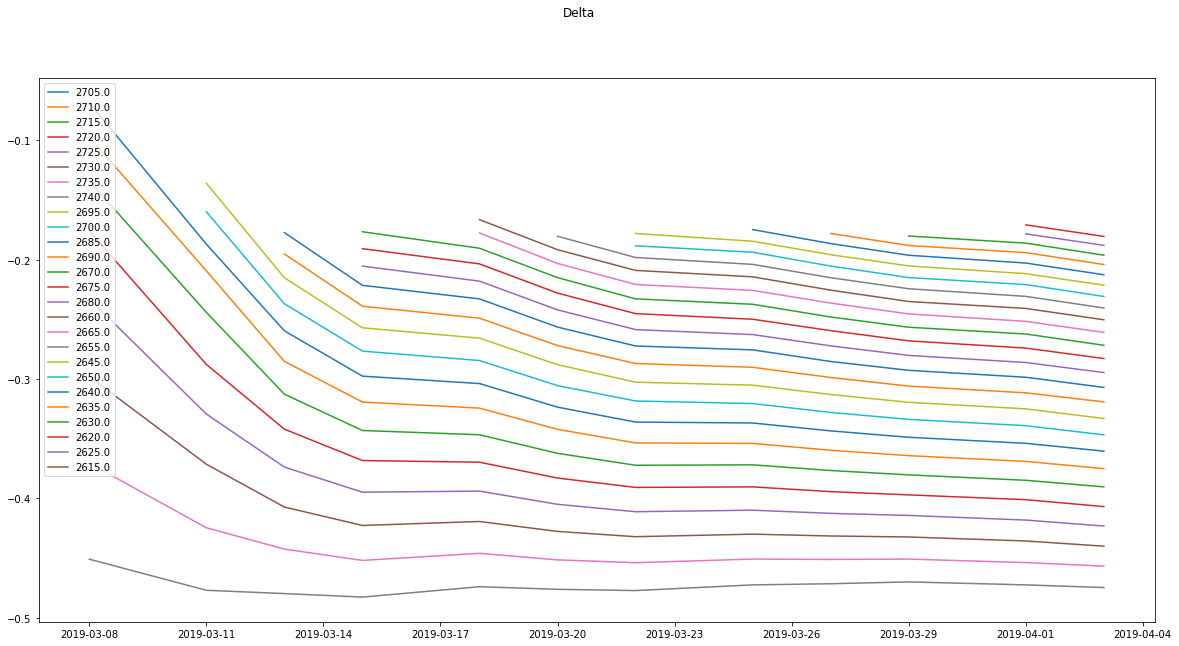

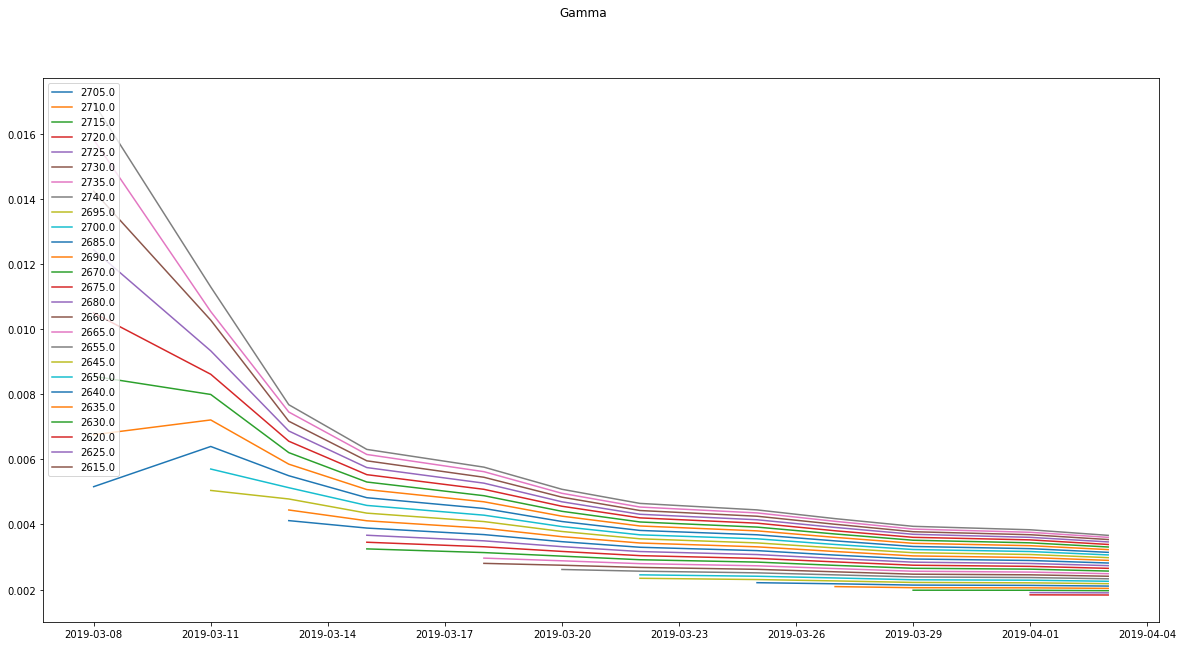

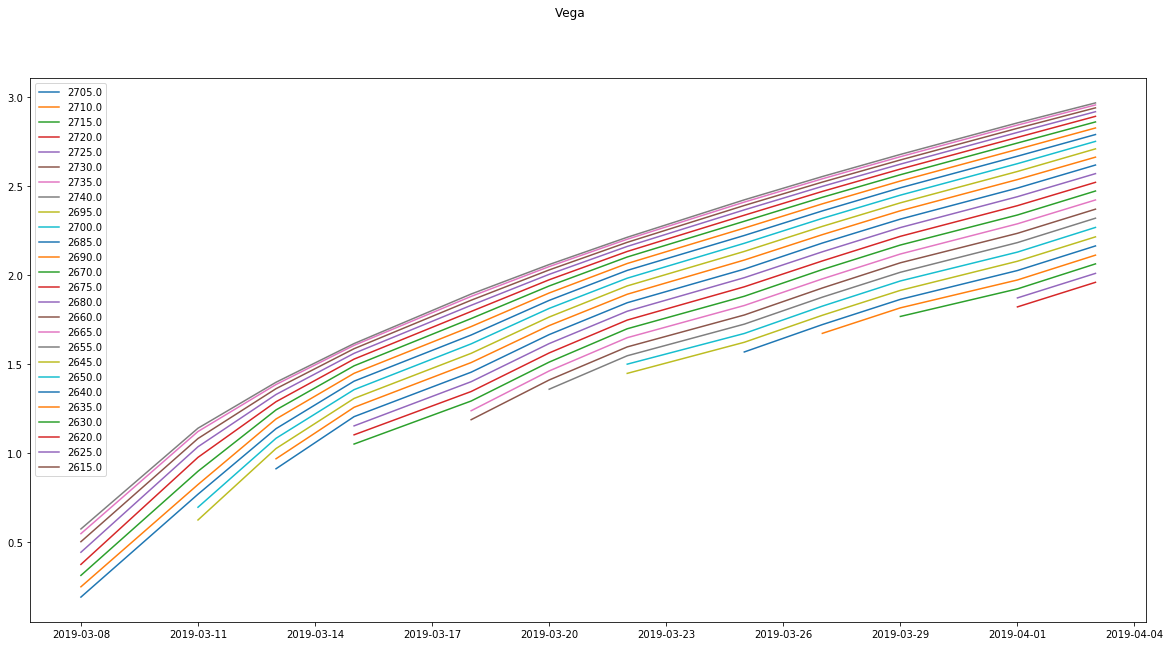

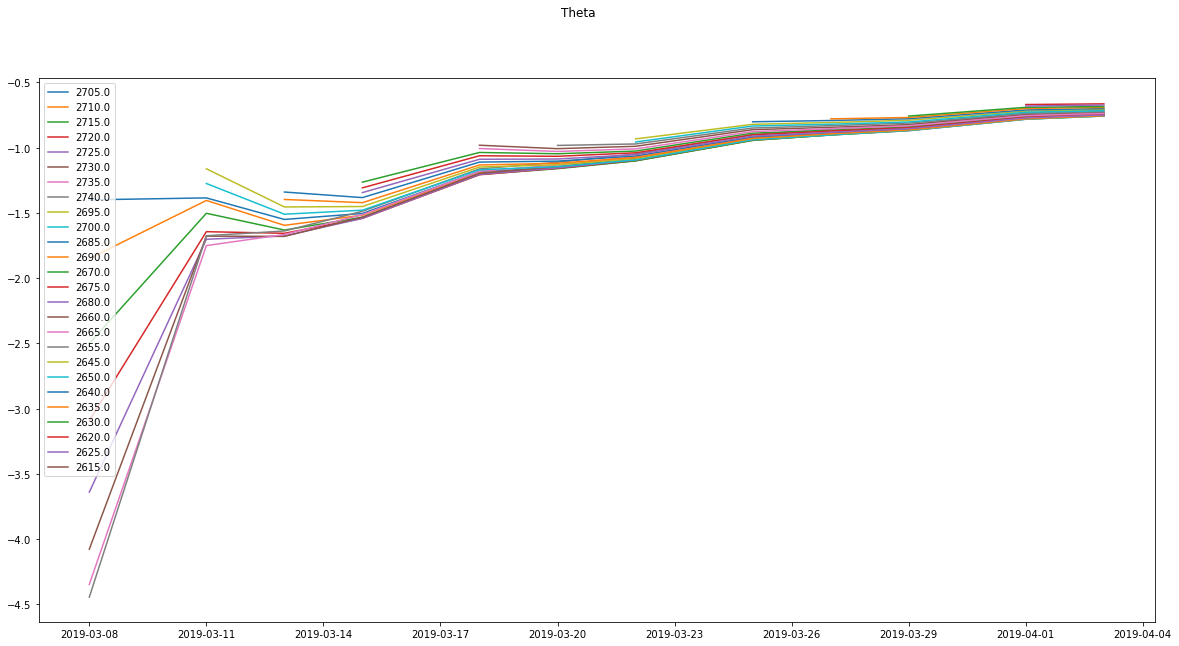

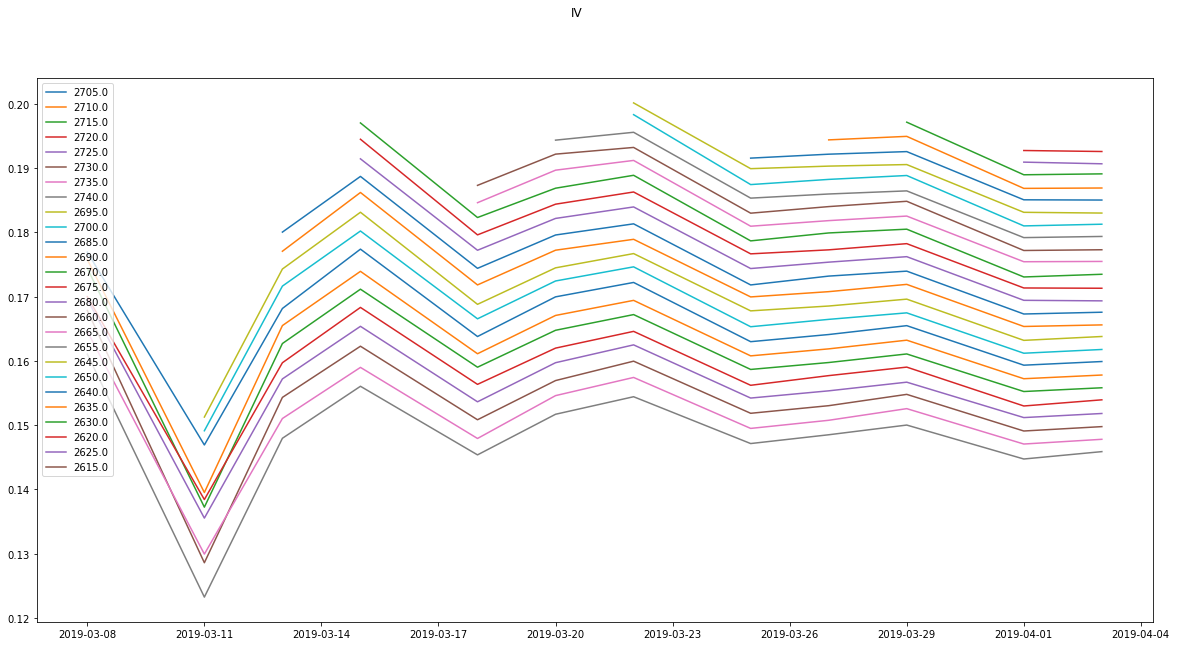

In [120]:
options_df = puts_df.copy()

strike_limit = 2745
for greek in ['Delta','Gamma','Vega','Theta','IV']:
    curr_greek = options_df[['Expiry','Strike','ask{}'.format(greek)]].set_index('Expiry')
    
    if options_df.loc[0,'Type'] == 'P':
        curr_greek = curr_greek[curr_greek.Strike < strike_limit]
    
    if options_df.loc[0,'Type'] == 'C':
        curr_greek = curr_greek[curr_greek.Strike > strike_limit]
    
    fig = plt.figure(figsize = (20,10))
    
    for strike in curr_greek.Strike.drop_duplicates().tolist():

        curr_plot = curr_greek[curr_greek.Strike == strike][['ask{}'.format(greek)]]
        curr_plot.columns = ['{0} {1}'.format(strike, greek)]

        plt.plot(curr_plot)
        
    fig.suptitle(greek)
    plt.legend(curr_greek.Strike.drop_duplicates(), loc='upper left')
    
    plt.show()

In [ ]:
# reg_estimates = pd.read_csv('reg_estimates.csv', index_col = 0)

# index_intraday = spx_df.join(vix_df, lsuffix = '_spx', rsuffix = '_vix').reset_index()
# #index_intraday[['date','close_spx','close_vix']].set_index('date').plot(figsize = (20,10), secondary_y = 'close_vix')
# latest_intraday_stats = day_block_stats(index_intraday)
# latest_intraday_stats['SPX_trend'] = latest_intraday_stats['SPX_OLS_Coeff']*latest_intraday_stats['SPX_OLS_R2']
# latest_intraday_stats['VIX_trend'] = latest_intraday_stats['VIX_OLS_Coeff']*latest_intraday_stats['VIX_OLS_R2']
# latest_intraday_stats['SPX_Forecast'] = np.nan

# for idx, row in latest_intraday_stats.iterrows():
#     curr_estimates = reg_estimates[reg_estimates.Block_Label == row.Block_Label]
#     curr_estimates = curr_estimates.join(row).iloc[:,[0,3]]
#     curr_estimates.columns = ['Coeff', 'Vals']
#     latest_intraday_stats.loc[idx,'SPX_Forecast'] = sum(curr_estimates.Coeff*curr_estimates.Vals)

# latest_intraday_stats = latest_intraday_stats.T
# latest_intraday_stats.columns = [time_block_strtoactual(i + 1) + " - " + time_block_strtoactual(i + 2) for i in latest_intraday_stats.columns.tolist()]
# latest_intraday_stats.iloc[1:,:]


In [ ]:
ib.disconnect()

puts = puts_df[puts_df.Expiry == expirations_dates[2]]

expiry_index = 0
rowshift = 1
show_weeklies = True

put_spreads, evs = get_spreads(puts, curr_spx, curr_vix, curr_skew, expiry_index, rowshift)
filtered_ps = put_spreads[(put_spreads.Credit > 0.5) & 
                          (abs(put_spreads.Short_Delta) < 0.6)].sort_values('EV', ascending = False)

if show_weeklies:
    commissions = 0.0266
    max_contracts = 10
    filtered_ps = []
    
    for rowshift in range(1,6):
        
        put_spreads, evs = get_spreads(puts, curr_spx, curr_vix, curr_skew, expiry_index, rowshift)
        put_spreads = put_spreads[(put_spreads.Credit > 0.5) & 
                                  (abs(put_spreads.Short_Delta) < 0.6)].sort_values('EV', ascending = False)
        filtered_ps.append(put_spreads)
    
    filtered_ps = pd.concat(filtered_ps, axis = 0).reset_index(drop = True)
    
    atm_puts = puts[(puts.Expiry == filtered_ps.reset_index(drop = True).loc[0, 'Expiry']) &
                    (abs((abs(puts.modelDelta) - 0.5)) <= 0.05)][['Expiry','Ask','Bid',
                                                                  'Strike','Type',
                                                                  'askDelta','bidDelta',
                                                                  'modelDelta']].sort_values('modelDelta', 
                                                                                             ascending = False).reset_index(drop = True)
    atm_delta = atm_puts.loc[0, 'modelDelta']
    atm_credit = atm_puts.loc[0, 'Bid']

    weekly_ps = filtered_ps.copy().reset_index(drop = True)
    weekly_ps['ContractsForATMEquiv'] = round(pd.to_numeric(atm_delta/weekly_ps.Delta),0)

    conversion_columns = ['Delta','Gamma','Theta','Vega','Credit','MaxLoss','EV']

    for col in conversion_columns:
        weekly_ps[col] = weekly_ps[col]*weekly_ps.ContractsForATMEquiv
    
    weekly_ps = weekly_ps[(weekly_ps.Credit >= atm_credit + weekly_ps.ContractsForATMEquiv*commissions) &
                          (weekly_ps.ContractsForATMEquiv <= max_contracts)].reset_index(drop = True)
    
weekly_ps.sort_values('MaxLoss', ascending = False)

#filtered_ps

In [55]:
ib.disconnect()